In [1]:
#!pip install Pillow
#!pip install pyproj

In [2]:
import requests
import numpy as np
import pandas as pd
from pyproj import Transformer
from PIL import Image

## Search the geo.admin API


In [3]:
_API_URL = 'https://api3.geo.admin.ch/rest/services/api/SearchServer'

In [4]:
def search_api_to_json(searchText, layer):
    url = f"{_API_URL}?type=locations&searchText={searchText}&origins={layer}"
    return requests.get(url).json()

In [5]:
# example:
result = search_api_to_json('bahnhofstrasse 6 windisch', 'address')

In [6]:
def lat_lon_from_json(json):
    lat = json['results'][0]['attrs']['lat']
    lon = json['results'][0]['attrs']['lon']
    return lat,lon

In [7]:
# example
lat_lon_from_json(result)

(47.48176574707031, 8.210972785949707)

In [8]:
def from_latitude_longitude_to_e_n(lat: float, long: float):
    transformer = Transformer.from_crs("epsg:4326", "epsg:2056")
    return transformer.transform(lat, long)

def from_e_n_to_latitude_longitude(e: float, n: float):
    transformer = Transformer.from_crs("epsg:2056", "epsg:4326")
    return transformer.transform(e, n)

## GIS images

In [9]:
def get_gis_image_url(e, n, radius, layers):
    l_e, r_e, t_n, b_n = e - radius, e + radius, n - radius, n + radius
    return f"https://wms.geo.admin.ch/?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&FORMAT=image%2Fpng&TRANSPARENT=false&LAYERS={','.join(layers)}&WIDTH={256}&HEIGHT={256}&CRS=epsg%3A2056&STYLES=&BBOX={l_e}%2C{t_n}%2C{r_e}%2C{b_n}"

In [10]:
# example
latitude, longitude = 47.48246574707031, 8.212472785949707
e, n = from_latitude_longitude_to_e_n(latitude, longitude)
image_url = get_gis_image_url(e, n, 100, ['ch.kantone.cadastralwebmap-farbe'])
image_url

'https://wms.geo.admin.ch/?SERVICE=WMS&VERSION=1.3.0&REQUEST=GetMap&FORMAT=image%2Fpng&TRANSPARENT=false&LAYERS=ch.kantone.cadastralwebmap-farbe&WIDTH=256&HEIGHT=256&CRS=epsg%3A2056&STYLES=&BBOX=2658226.026306313%2C1259264.973784022%2C2658426.026306313%2C1259464.973784022'

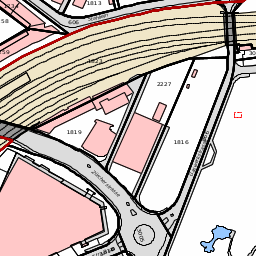

In [11]:
img = Image.open(requests.get(image_url, stream=True).raw)
img

## Analyze GIS images with PIL or numpy

In [12]:
building = 0
img_size = 256 * 256

for pixel in img.getdata():
    if pixel == (255, 200, 200, 255): # color of buildings (RGB + opacity)
        building += 1
print(f'Percentage of image showing a building: {(building / img_size) * 100}%')

Percentage of image showing a building: 16.33453369140625%


In [13]:
# alternative with numpy
data = np.asarray(img, dtype="int32")
data = data.reshape(img_size, 4)
building_pixels = np.where((data == (255, 200, 200, 255)).all(axis=1))

print(f'Percentage of image showing a building: {(len(building_pixels[0]) / img_size) * 100}%')

Percentage of image showing a building: 16.33453369140625%


# Task 1
Create a function where you can pass an address, e.g. "bahnhofstrasse 6 windisch" and it will return you a boolean which is true if that address is within 200m of water (river or sea). You can use the geo.admin layer 'ch.bafu.ren-fliessgewaesser_seen' for this task. Use the functions already defined in this notebook. Hint: it is not necessary to find the color of water in this map (although it is one possible option) - it might be easier to look for where water is not.

In [16]:
def is_next_to_water(address):
    response = search_api_to_json(address, 'address')
    lat, lon = lat_lon_from_json(response)
    e, n = from_latitude_longitude_to_e_n(lat, lon)
    image_url = get_gis_image_url(e, n, 200, ['ch.bafu.ren-fliessgewaesser_seen'])
    img = Image.open(requests.get(image_url, stream=True).raw)
    for pixel in img.getdata():
        if pixel != (255, 255, 255, 255): # white (RGB + Opacity)
            return True
    return False

In [17]:
is_next_to_water("bahnhofstrasse 6 windisch")

False

In [18]:
is_next_to_water("Kapellplatz 1, Luzern")

True